In [103]:
%matplotlib widget

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns



# 1. Lecture du fichier
df = pd.read_csv("data\Kangaroo.csv")

### Drop columns

In [104]:

# 2. Liste des colonnes à supprimer 
cols_to_drop = [
    "Unnamed: 0", "id", "url", "roomCount", "monthlyCost",
    "hasAttic", "hasBasement", "hasDressingRoom", "diningRoomSurface", "hasDiningRoom",
    "streetFacadeWidth", "hasLift", "hasHeatPump",
    "hasPhotovoltaicPanels", "hasThermicPanels", "kitchenSurface",
    "hasLivingRoom", "livingRoomSurface", "hasBalcony",
    "gardenOrientation", "parkingCountIndoor", "parkingCountOutdoor",
    "hasAirConditioning", "hasArmoredDoor", "hasVisiophone", "hasOffice",
    "terraceSurface", "terraceOrientation", "accessibleDisabledPeople"
]

# 3. Suppression
df.drop(cols_to_drop, axis=1, inplace=True)

### Grouping subtypes

In [105]:
# Subtype_grouped
subtype_mapping = {
    'EXCEPTIONAL_PROPERTY': 'LUXURY_PROPERTY',
    'VILLA': 'LUXURY_PROPERTY',
    'MANSION': 'LUXURY_PROPERTY',
    'CASTLE': 'LUXURY_PROPERTY',
    'MANOR_HOUSE': 'LUXURY_PROPERTY',
    'HOUSE': 'STANDARD_HOUSE',
    'TOWN_HOUSE': 'STANDARD_HOUSE',
    'BUNGALOW': 'STANDARD_HOUSE',
    'PAVILION': 'STANDARD_HOUSE',
    'COUNTRY_COTTAGE': 'RURAL_HOUSE',
    'FARMHOUSE': 'RURAL_HOUSE',
    'CHALET': 'RURAL_HOUSE',
    'APARTMENT': 'STANDARD_APARTMENT',
    'GROUND_FLOOR': 'STANDARD_APARTMENT',
    'FLAT_STUDIO': 'STANDARD_APARTMENT',
    'SERVICE_FLAT': 'STANDARD_APARTMENT',
    'KOT': 'STANDARD_APARTMENT',
    'PENTHOUSE': 'SPECIAL_APARTMENT',
    'DUPLEX': 'SPECIAL_APARTMENT',
    'TRIPLEX': 'SPECIAL_APARTMENT',
    'LOFT': 'SPECIAL_APARTMENT',
    'MIXED_USE_BUILDING': 'MIXED_USE',
    'OTHER_PROPERTY': 'OTHER'
}
# Appliquer le mapping
df['subtype_grouped'] = df['subtype'].map(subtype_mapping)
# Drop column: 'subtype'
df = df.drop(columns=['subtype'])

### Check and drop Outliers

Data visualization for outliers

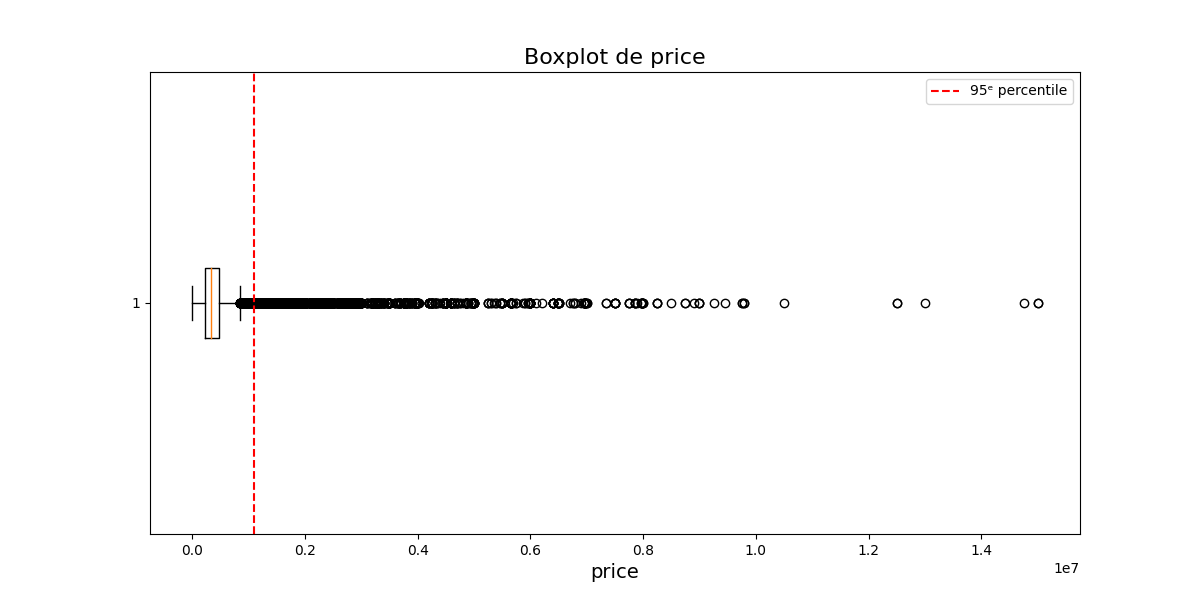

10ᵉ percentile : 165000
90ᵉ percentile : 765000
95ᵉ percentile : 1100000
Biens > p90 : 7605 soit 9.46%
Biens > p95 : 3817 soit 4.75%
Biens < p10 : 7377 soit 9.18%
Mode de price : 299000.0


In [106]:
#Datavisualization for outliers

# Sans NaN
data = df["price"].dropna()


p10, p90, p95 = data.quantile([0.10, 0.90, 0.95]).values

# 3) Boxplot horizontal avec ligne pour le 95ᵉ percentile
fig, ax = plt.subplots(figsize=(12, 6))
ax.boxplot(data, vert=False, showfliers=True)
ax.axvline(p95, color="red", linestyle="--", label="95ᵉ percentile")
ax.set_title("Boxplot de price", fontsize=16)
ax.set_xlabel("price", fontsize=14)
ax.legend()
plt.show()


# 4) Affichage des percentiles et des effectifs
print(f"10ᵉ percentile : {p10:.0f}")
print(f"90ᵉ percentile : {p90:.0f}")
print(f"95ᵉ percentile : {p95:.0f}")

total = len(df)
n_above_p90 = (df['price'] > p90).sum()
n_above_p95 = (df['price'] > p95).sum()
n_below_p10 = (df['price'] < p10).sum()

print(f"Biens > p90 : {n_above_p90} soit {n_above_p90/total:.2%}")
print(f"Biens > p95 : {n_above_p95} soit {n_above_p95/total:.2%}")
print(f"Biens < p10 : {n_below_p10} soit {n_below_p10/total:.2%}")

# 5) Calcul et affichage du mode (première valeur si plusieurs)
mode_floor = df['price'].mode().iloc[0]
print(f"Mode de price : {mode_floor}")


In [107]:
# Fermer graph pour libérer la mémoire
plt.close("all")

Keep bedrooms <= 7

In [108]:
df = df[
    (df["bedroomCount"] <= 7) | df["bedroomCount"].isna()
]


Keep houses contructed between 1850 and 2025

In [109]:
df = df[
    (df["buildingConstructionYear"].between(1850, 2025)) | df["buildingConstructionYear"].isna()
]

Bathrooms count <= 3

In [110]:
df = df[
    (df["bathroomCount"] <= 3) | df["bathroomCount"].isna()
]

Habitable surface

In [111]:
# Fourchettte entre 5 et 500 m² pour rester dans un marché immo le plus représentatif
df_domain = df[(df["habitableSurface"] >= 5) & (df["habitableSurface"] <= 500)]

Facede count
Max. 4

In [112]:
df = df[
    (df["facedeCount"] <= 4) | df["facedeCount"].isna()
]

FloorCount

 Séparation du champ unique `floorCount` en deux colonnes distinctes :
  - `building_floors`  : nombre total d'étages du bâtiment (valide pour les maisons)
  - `apartment_floor`  : étage où se situe l’appartement (valide pour les appartements)
  
 Méthode :
 1) On teste, ligne par ligne, si `propertyType` vaut "house" ou "apartment".
 2) Si c'est une maison, on recopie `floorCount` dans `building_floors` et on met NaN dans `apartment_floor`.
 3) Si c'est un appartement, on recopie `floorCount` dans `apartment_floor` et on met NaN dans `building_floors`.
 4) Enfin, on supprime l’ancienne colonne `floorCount` car elle n’est plus nécessaire.


In [113]:

df['building_floors'] = np.where(
    df['type'] == 'HOUSE',
    df['floorCount'],
    np.nan
)

df['apartment_floor'] = np.where(
    df['type'] == 'APARTMENT',
    df['floorCount'],
    np.nan
)

df = df.drop(columns=['floorCount'])


landSurface

<= 2000 m²

In [114]:
df = df[
    (df["landSurface"] <= 2000) | df["landSurface"].isna()
]

Garden surface :
- Drop outliers > 2000 m²
- If NaN, it's because there is not garden because the col hasGarden have the same values missings count
- Convert hasGarden in bool
- If hasGarden = False --> gardenSurface = 0

In [115]:
# Drop outliers
df = df[
    (df["gardenSurface"] <= 2000) | df["gardenSurface"].isna()
]

# Convert hasGaren in bool
df['hasGarden'] = df['hasGarden'].fillna(False).astype(bool)
print(df['hasGarden'].dtype)

# False --> 0
df.loc[df['hasGarden'] == False, 'gardenSurface'] = 0

# print(df[['hasGarden','gardenSurface']].head(10))


bool


Toilet count <= 3 (95% percentile)

In [116]:
df = df[
    (df["toiletCount"] <= 3) | df["toiletCount"].isna()
]

Price
<= 1.000.000€

In [117]:
df = df[
    (df["price"] <= 1000000) | df["price"].isna()
]

### Handle epcScore

In [118]:
def epcToNumeric(row):
    region = row['region']
    epc_score = row['epcScore']
    
    epc_mapping = {
        'Flanders': {
            'A++': 0,
            'A+': 0,
            'A': 100,
            'B': 200,
            'C': 300,
            'D': 400,
            'E': 500,
            'F': 600,
            'G': 700
        },
        'Wallonia': {
            'A++': 0,
            'A+': 50,
            'A': 90,
            'B': 170,
            'C': 250,
            'D': 330,
            'E': 420,
            'F': 510,
            'G': 600
        },
        'Bruxelles': {
            'A++': 0,
            'A+': 0,
            'A': 45,
            'B': 95,
            'C': 145,
            'D': 210,
            'E': 275,
            'F': 345,
            'G': 450
        }
    }
    
    return epc_mapping.get(region, {}).get(epc_score, None)

### Check type for each features

In [119]:
# Check type

for col in df.columns:
    print(f"{col} : {df[col].dtype}")



type : object
bedroomCount : float64
bathroomCount : float64
province : object
locality : object
postCode : int64
habitableSurface : float64
buildingCondition : object
buildingConstructionYear : float64
facedeCount : float64
floodZoneType : object
heatingType : object
kitchenType : object
landSurface : float64
hasGarden : bool
gardenSurface : float64
toiletCount : float64
hasSwimmingPool : object
hasFireplace : object
hasTerrace : object
epcScore : object
price : float64
subtype_grouped : object
building_floors : float64
apartment_floor : float64


#### Adapt type for each features

type : object --> str

bedroomCount : float64 --> Int64

bathroomCount : float64 --> Int64

province : object --> str

locality : object --> str

postCode : Int64 --> str 

habitableSurface : float64

buildingCondition : object --> str

buildingConstructionYear : float64 --> Int64

facedeCount : float64 --> Int64

floodZoneType : object --> str

heatingType : object --> str

kitchenType : object --> str

landSurface : float64 

hasGarden : bool

gardenSurface : float64

toiletCount : float64 --> Int64

hasSwimmingPool : object --> bool

hasFireplace : object --> bool

hasTerrace : object --> bool

epcScore : object --> cf. def epcToNumeric from Robin

price : float64

subtype_grouped : object --> str

building_floors : float64 --> Int64

apartment_floor : float64 --> Int64


In [120]:
df = df.convert_dtypes()

df.dtypes

type                        string[python]
bedroomCount                         Int64
bathroomCount                        Int64
province                    string[python]
locality                    string[python]
postCode                             Int64
habitableSurface                     Int64
buildingCondition           string[python]
buildingConstructionYear             Int64
facedeCount                          Int64
floodZoneType               string[python]
heatingType                 string[python]
kitchenType                 string[python]
landSurface                          Int64
hasGarden                          boolean
gardenSurface                        Int64
toiletCount                          Int64
hasSwimmingPool                    boolean
hasFireplace                       boolean
hasTerrace                         boolean
epcScore                    string[python]
price                                Int64
subtype_grouped             string[python]
building_fl

In [ ]:
# postCode to str / treat it as an identifier/category, not as a number

df["postCode"] = df["postCode"].astype("string")

df.dtypes

# epcScore --> Int64

type                        string[python]
bedroomCount                         Int64
bathroomCount                        Int64
province                    string[python]
locality                    string[python]
postCode                    string[python]
habitableSurface                     Int64
buildingCondition           string[python]
buildingConstructionYear             Int64
facedeCount                          Int64
floodZoneType               string[python]
heatingType                 string[python]
kitchenType                 string[python]
landSurface                          Int64
hasGarden                          boolean
gardenSurface                        Int64
toiletCount                          Int64
hasSwimmingPool                    boolean
hasFireplace                       boolean
hasTerrace                         boolean
epcScore                    string[python]
price                                Int64
subtype_grouped             string[python]
building_fl

### 

- normaliser les chiffres --> scaler = Pycaret
- remplacer les values de majuscules à MajMin
- traduire en français
- vérifier l'harmonisation des données de provinces
- harmoniser les locality
- réflechir comment gérer les types de cuisines (je garde les USA ou non)

Corrélation

                          bedroomCount  bathroomCount  habitableSurface  \
bedroomCount                  1.000000       0.379382          0.071856   
bathroomCount                 0.379382       1.000000          0.032780   
habitableSurface              0.071856       0.032780          1.000000   
buildingConstructionYear      0.172016       0.037115          0.041573   
facedeCount                   0.222037       0.036075          0.025494   
landSurface                   0.173256       0.071083          0.023087   
hasGarden                     0.207873       0.056156          0.024943   
gardenSurface                 0.188866       0.061125          0.024351   
toiletCount                   0.530228       0.491386          0.052035   
hasSwimmingPool                    NaN            NaN               NaN   
hasFireplace                       NaN            NaN               NaN   
hasTerrace                         NaN            NaN               NaN   
price                    

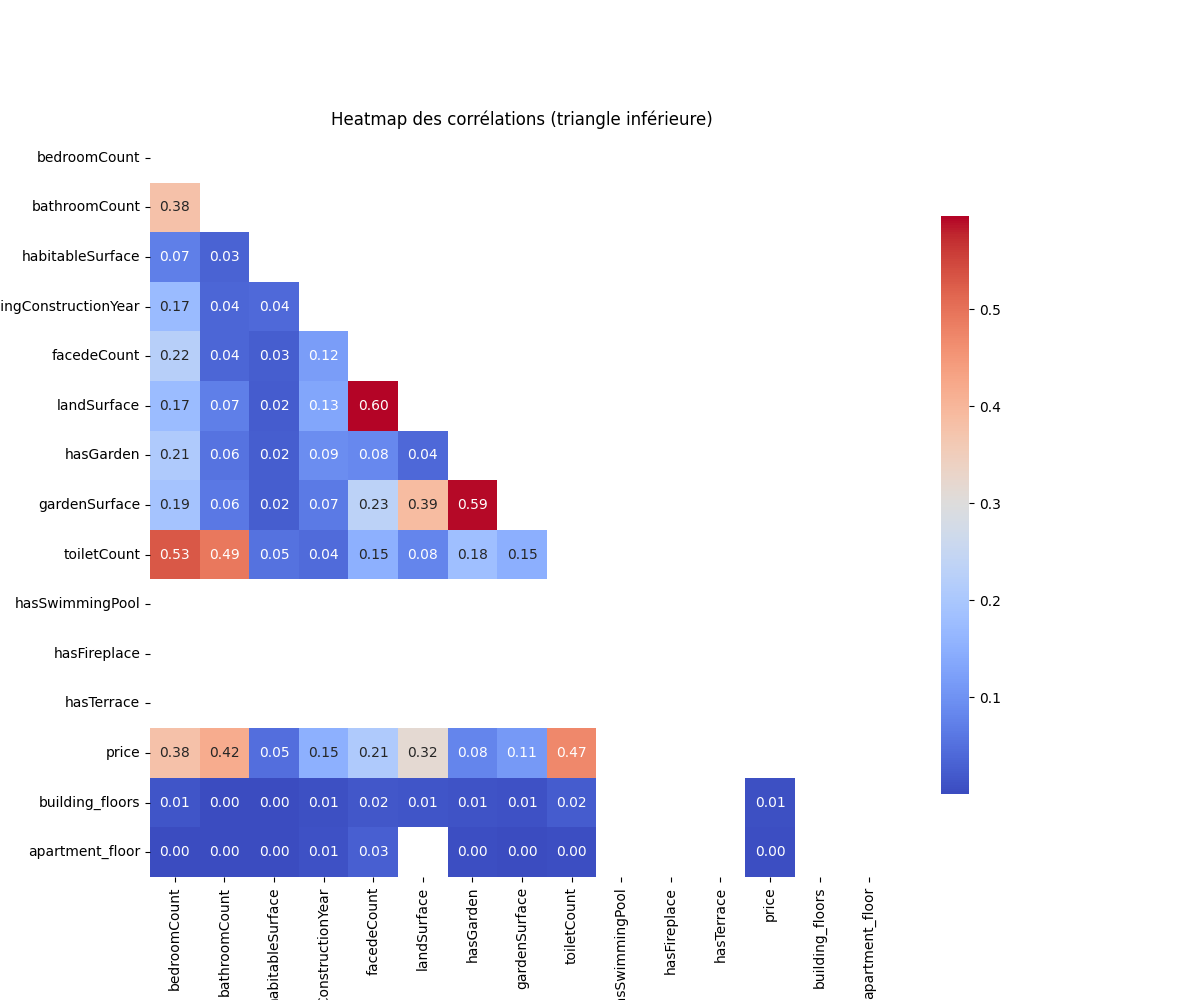

In [122]:
corr_matrix = df.corr(numeric_only=True).abs()
print(corr_matrix)


# masque la triangle supérieure
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    cbar_kws={"shrink": .75}
)
plt.title("Heatmap des corrélations (triangle inférieure)")
plt.show()